In [1]:
import operator
import numpy as np
import pandas as pd
import random
# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('talk')

In [2]:
import ipyparallel as ipp
rc = ipp.Client()
rc.ids

[0, 1, 2, 3, 4]

In [3]:
dview = rc[:]
lbview = rc.load_balanced_view()

In [4]:
%%px  --local 
from time import sleep
from datetime import datetime
import random
import os
pid = os.getpid()  # every engines will be different
print(pid)

15448
[stdout:0] 12388
[stdout:1] 7104
[stdout:2] 16412
[stdout:3] 8348
[stdout:4] 22316


In [5]:
engines_pid = dview.get('pid')
pid_id_map = {pid: id for pid, id in zip(engines_pid, rc.ids)}

In [6]:
print(engines_pid)
print(pid_id_map)

[12388, 7104, 16412, 8348, 22316]
{12388: 0, 7104: 1, 16412: 2, 8348: 3, 22316: 4}


In [7]:
num_engines = len(rc.ids)
total_works = num_engines * 5 + 2

def high_variated_work(i):
    start_time = datetime.now()
    base_workload = 10
    if i  < (total_works // num_engines):
        base_workload *= 5
    # so short task: 200ms long task: 1s
    sleep(base_workload * 20 / 1000)
    end_time = datetime.now()
    return pid, start_time, end_time

In [8]:
dview['num_engines'] = num_engines
dview['total_works'] = total_works

In [9]:
# lb: load balance, ar: async result
lb_ar = lbview.map_async(high_variated_work, range(total_works))

In [10]:
lb_ar.wait_interactive()


done


In [11]:
# d: direct
d_ar = dview.map_async(high_variated_work, range(total_works))

In [12]:
d_ar.wait_interactive()


done


In [13]:
def parse_async_meta(async_result):
    """Parse async result as pandas.DataFrame"""
    meta_df = pd.DataFrame(async_result.get(), columns=['engine_pid', 'started', 'completed'])
    meta_df['engine_id'] = meta_df['engine_pid'].map(pid_id_map)
    return meta_df

In [14]:
def make_rel_time(meta_df):
    """Convert exact timestamp relative to start time and sort."""
    def compute_rel_time(col):
        """Relative time elapse compared with start time in seconds"""
        return [(val - start_time).total_seconds() for val in col]
    
    ## Make all time data relative to the start time in seconds
    # create empty dataframe
    df_rel_sec = meta_df[['engine_id']].copy()
    rel_columns = ['rel_started', 'rel_completed']
    for col in rel_columns:
        df_rel_sec[col] = np.empty(len(df_rel_sec), np.float)
        
    # get the earliest start time
    start_time = meta_df.started.min()
    abs_time_data = meta_df[['started', 'completed']]
    rel_time_data = abs_time_data.apply(compute_rel_time, axis=0).values
    df_rel_sec.loc[:, rel_columns] = rel_time_data
    
    # sort by relative start time and given order, 
    # grouped by different engines
    sorted_df = df_rel_sec.sort_values(['engine_id', 'rel_started', 'rel_completed'])
    sorted_df['order'] = np.empty(len(sorted_df), np.int)
    for grp_key, grp_df in sorted_df.groupby(['engine_id']):
        sorted_df.loc[grp_df.index, 'order'] = np.arange(len(grp_df))
    
    return sorted_df

In [15]:
def get_color_pal(max_jobs_per_engines):
    color_pal = sns.cubehelix_palette(
        n_colors=max_jobs_per_engines,
        start=2.3, rot=0.8, gamma=0.6, hue=0.8, 
        light=0.9, dark=0.3, 
        reverse=True
    )
    return color_pal


def plot_meta_df(meta_df, figsize=None):
    # some boundaries required for plotting
    max_jobs_per_engines = meta_df['order'].max() + 1
    num_engines = len(np.unique(meta_df['engine_id']))
    color_pal = get_color_pal(max_jobs_per_engines)
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(max_jobs_per_engines * 6 * 2 / 6, 6))
    ax = plt.axes()
    bar_height = 0.8
    for ix, row in meta_df.iterrows():
        plt.bar(
            bottom=int(row.engine_id) , x=row.rel_started + 0.5, 
            width=row.rel_completed - row.rel_started, height=bar_height,
            color=color_pal[int(row['order'])], axes=ax
        )
    plt.xlabel('Time (second)')
    plt.ylabel('Engine')
    plt.yticks(
        np.arange(num_engines) + bar_height / 2, 
        ['%2d' % ix for ix in np.arange(num_engines)]
    )
    return fig

In [16]:
lb_ar_df, d_ar_df = map(make_rel_time, map(parse_async_meta, [lb_ar, d_ar]))

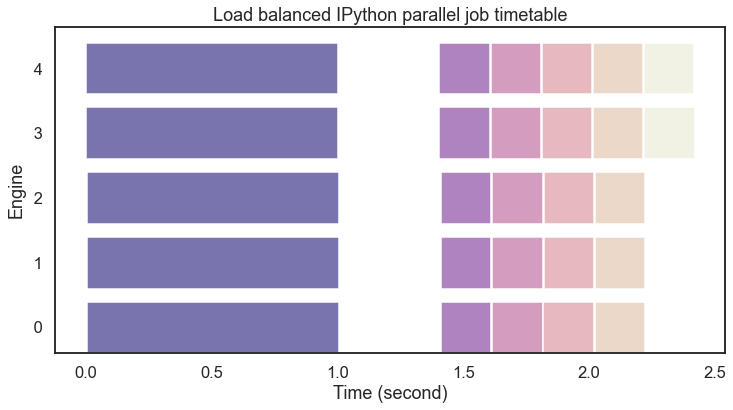

In [17]:
fig = plot_meta_df(lb_ar_df)
plt.title('Load balanced IPython parallel job timetable')
plt.show()

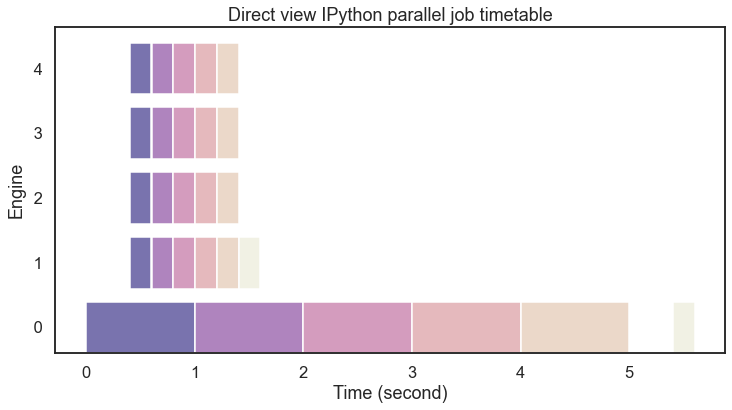

In [18]:
fig = plot_meta_df(d_ar_df)
plt.title('Direct view IPython parallel job timetable')
plt.show()

In [19]:
speedup = lambda ar: ar.serial_time / ar.wall_time
print(
    'Speedup for load-blanced and direct view (ideal: {:d}x): {:.2f} and {:.2f}'
    .format(num_engines, *map(speedup, [lb_ar, d_ar]))
)

Speedup for load-blanced and direct view (ideal: 5x): 4.64 and 1.81


In [25]:
import os
ar = rc[:].apply_async(os.getpid)

In [26]:
ar.wait()

True

In [27]:
pids = ar.get_dict()

In [28]:
print(pids)

{0: 12388, 1: 7104, 2: 16412, 3: 8348, 4: 22316}
